<a href="https://colab.research.google.com/github/stwind/notebooks/blob/master/normal-dist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

tfd, tfb = tfp.distributions, tfp.bijectors

rc = {
    'font.family': ['sans-serif'],
    'font.sans-serif': ['Open Sans', 'Arial Unicode MS'],
    'font.size': 12,
    'figure.figsize': (8, 6),
    'grid.linewidth': 0.5,
    'legend.fontsize': 10,
    'legend.frameon': True,
    'legend.framealpha': 0.6,
    'legend.handletextpad': 0.2,
    'lines.linewidth': 1,
    'axes.facecolor': '#fafafa',
    'axes.labelsize': 11,
    'axes.titlesize': 14,
    'axes.linewidth': 0.5,
    'xtick.labelsize': 11,
    'xtick.major.width': 0.5,
    'ytick.labelsize': 11,
    'ytick.major.width': 0.5,
    'figure.titlesize': 14,
}
sns.set('notebook', 'whitegrid', rc=rc)

## Univariate

$$\mathcal{N}(\mu, \sigma^2)$$

$$p(x \mid \mu, \sigma^2) = \frac{1}{\sqrt{2\pi}\sigma} \exp{ \left( -\frac{(x - \mu)^2}{2\sigma^2}\right)}$$

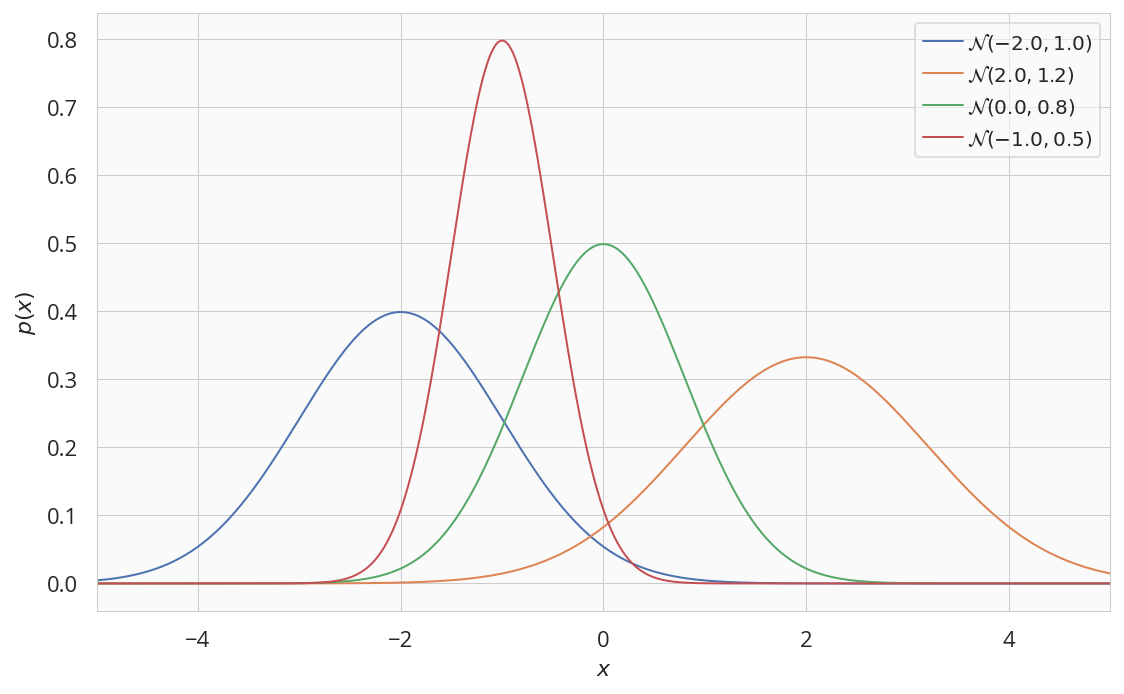

In [2]:
fig, ax = plt.subplots(figsize=(8, 5))

x = np.linspace(-5, 5, 500)
for loc, std in [[-2,1.0],[2,1.2],[0,0.8],[-1,0.5]]:
    normal = tfd.Normal(loc, std)
    label = '$\mathcal{{N}}({:.1f},{:.1f})$'.format(loc, std)
    ax.plot(x, normal.prob(x), label=label)

ax.set(xlabel='$x$',ylabel='$p(x)$',xlim=(-5,5))
ax.legend()

plt.tight_layout()
# plt.savefig('norm-dist-01.png',bbox_inches='tight',dpi=150)
plt.show()

## Multivariate

$$p(\boldsymbol{x}; \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \frac{1}{\sqrt{(2\pi)^n|\boldsymbol{\Sigma}|}} \exp\left( -\frac{1}{2}(\boldsymbol{x}-\boldsymbol{\mu})^\mathrm{T}\boldsymbol{\Sigma}^{-1}(\boldsymbol{x}-\boldsymbol{\mu})\right),$$

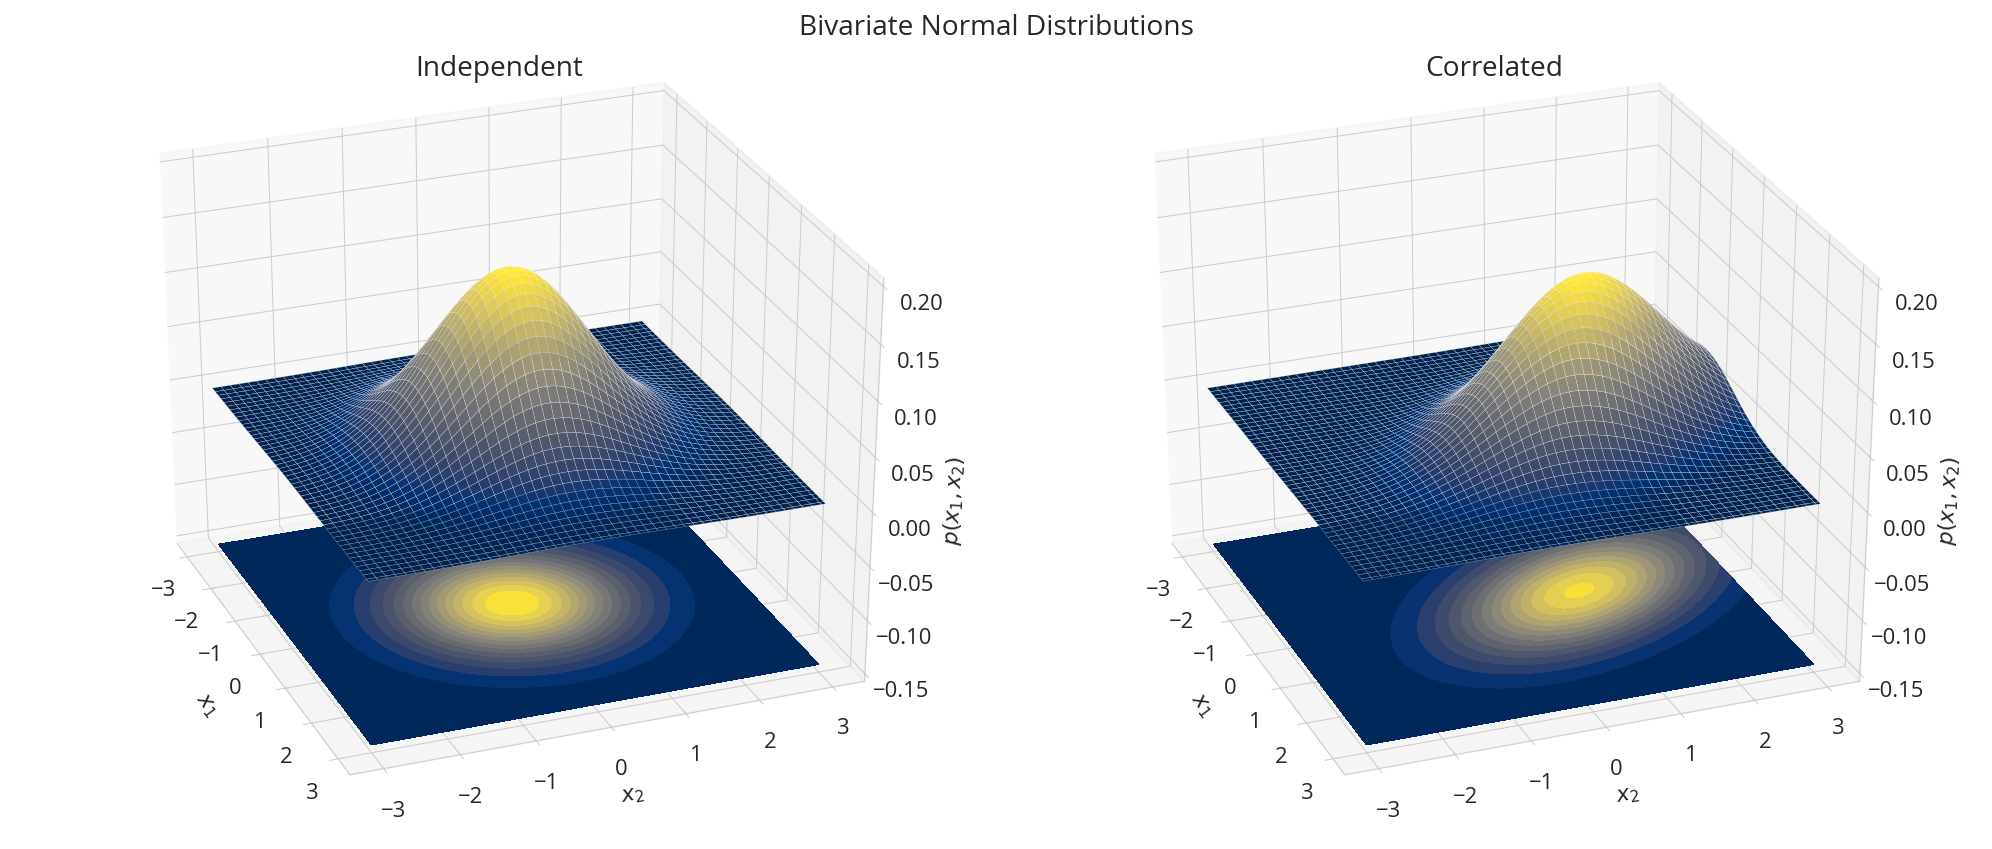

In [3]:
nd1 = tfd.MultivariateNormalTriL(loc=[0., 0.], scale_tril=tf.linalg.cholesky([[1.,0.],[0., 1.]]))
nd2 = tfd.MultivariateNormalTriL(loc=[0., 1.], scale_tril=tf.linalg.cholesky([[1.,-0.5],[-0.5, 1.5]]))

X1, X2 = np.meshgrid(np.linspace(-3,3,100), np.linspace(-3,3,100))
X = np.dstack((X1, X2))
data = [["Independent", nd1.prob(X)], ["Correlated", nd2.prob(X)]]

fig = plt.figure(figsize=(14, 6))

for i, (title, y) in enumerate(data):
    ax = fig.add_subplot(1, 2, i + 1, projection='3d')
    ax.plot_surface(X1, X2, y, rstride=2, cstride=2, linewidth=0.1, antialiased=True, cmap='cividis')
    ax.contourf(X1, X2, y, 15, zdir='z', offset=-0.15, cmap='cividis')
    ax.view_init(30, -21)
    ax.tick_params(color='0.8')
    ax.set(title=title,
           zlim=(-0.15, 0.2),
           xlabel='$x_1$',ylabel="$x_2$",zlabel="$p(x_1,x_2)$",
           fc='none')
    
fig.suptitle("Bivariate Normal Distributions")

plt.tight_layout()
# plt.savefig('norm-dist-02.png',bbox_inches='tight',dpi=150)
plt.show()

## Sampling

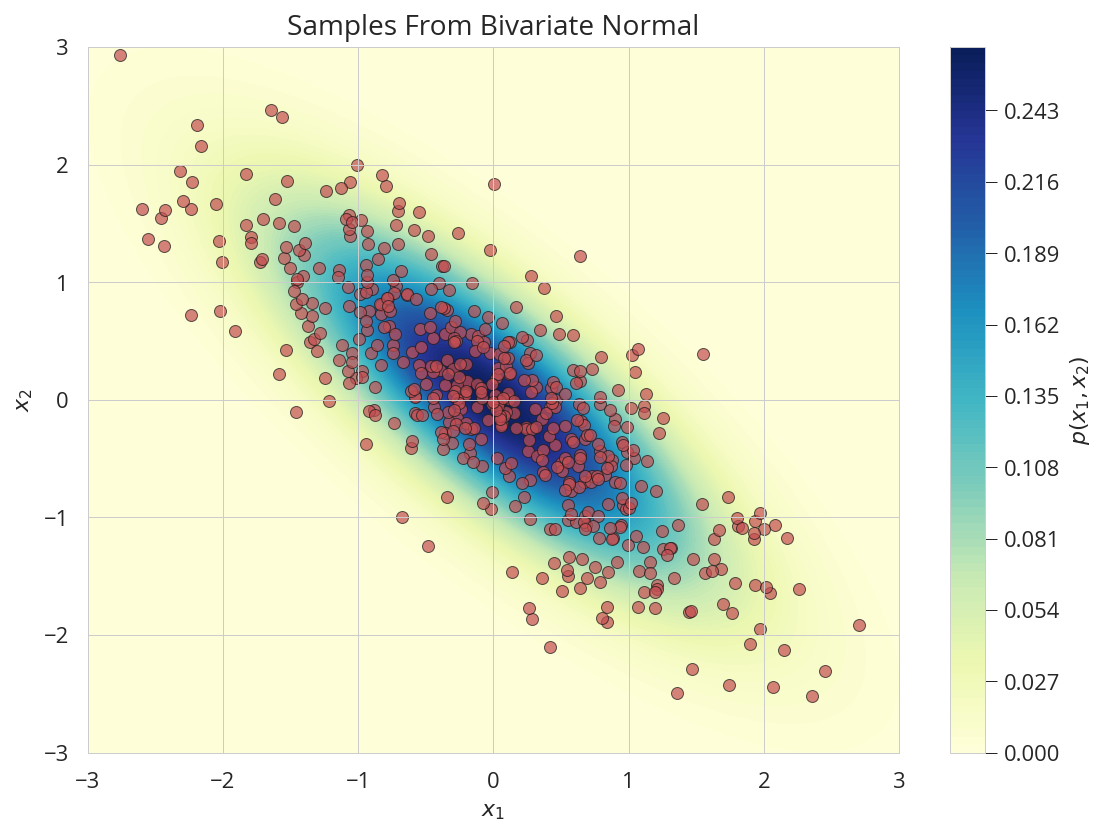

In [4]:
nd = tfd.MultivariateNormalTriL(loc=[0., 0.], scale_tril=tf.linalg.cholesky([[1.0,-0.2],[-0.8,1.]]))

X1, X2 = np.meshgrid(np.linspace(-3,3,100), np.linspace(-3,3,100))
Z = nd.prob(np.dstack((X1, X2)))
Y = nd.sample(500)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(Y[:,0], Y[:,1], 'ro',alpha=.7, markeredgecolor='k', markeredgewidth=0.5)

con = ax.contourf(X1, X2, Z, 100, cmap='YlGnBu')
ax.set(xlabel='$x_1$',ylabel='$x_2$', axisbelow=False,
       xlim=(-3,3),ylim=(-3,3),
       title='Samples From Bivariate Normal')

cbar = fig.colorbar(con)
cbar.ax.set_ylabel('$p(x_1, x_2)$')

plt.tight_layout()
# plt.savefig('norm-dist-03.png',bbox_inches='tight',dpi=150)
plt.show()

## Marginal and Conditional

In [5]:
mean = np.array([0., 0.])
cov = np.array([[1.0,0.7],[0.7,1.]])
nd = tfd.MultivariateNormalTriL(loc=mean, scale_tril=tf.linalg.cholesky(cov))
nx, ny = tfd.Normal(mean[0], cov[1, 1]), tfd.Normal(mean[1], cov[0, 0])

x, y = np.linspace(-3,3,100), np.linspace(-3,3,100)
X1, X2 = np.meshgrid(x, y)
Z = nd.prob(np.dstack((X1, X2)))

### Marginal

$$
\begin{bmatrix}
\mathbf{x} \\
\mathbf{y} 
\end{bmatrix}
\sim
\mathcal{N}\left(
\begin{bmatrix}
\mu_{\mathbf{x}} \\
\mu_{\mathbf{y}}
\end{bmatrix},
\begin{bmatrix}
A & C \\
C^T & B
\end{bmatrix}
\right)
= \mathcal{N}(\mu, \Sigma)
, \qquad 
\Sigma^{-1} = \Lambda = 
\begin{bmatrix}
\tilde{A} & \tilde{C} \\
\tilde{C}^T & \tilde{B}
\end{bmatrix}
$$

$$
\begin{split}
p(\mathbf{x}) & = \mathcal{N}(\mu_{\mathbf{x}}, A) \\
p(\mathbf{y}) & = \mathcal{N}(\mu_{\mathbf{y}}, B)
\end{split}
$$

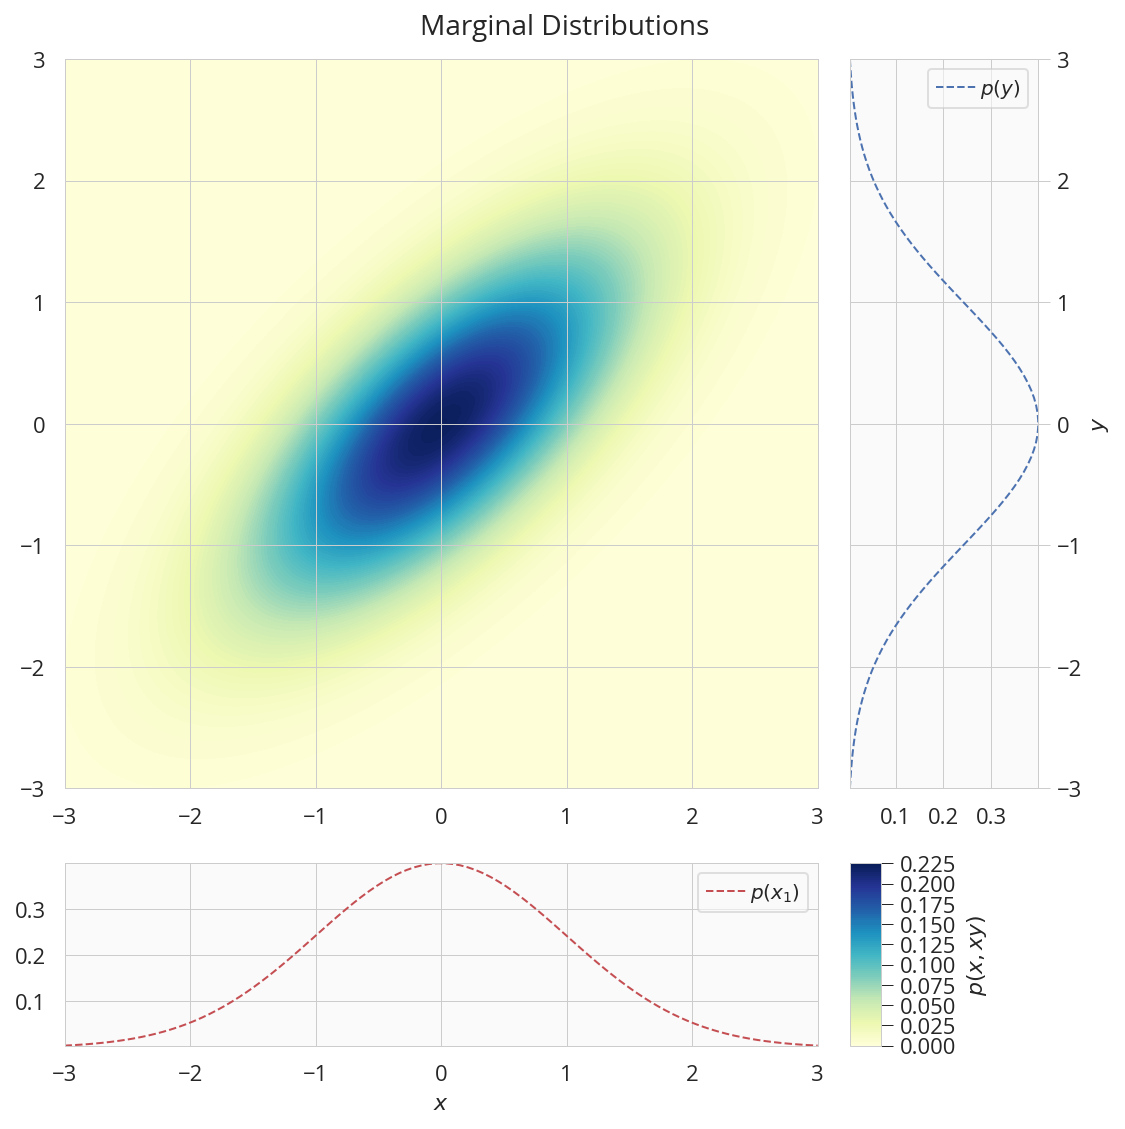

In [6]:
fig = plt.figure(figsize=(8, 8))

gs = GridSpec(2, 2, width_ratios=[8,2], height_ratios=[8,2])

ax = plt.subplot(gs[0])
con = ax.contourf(X1, X2, Z, 100, cmap='YlGnBu')
ax.set(axisbelow=False)
ax.autoscale(tight=True)

ax = plt.subplot(gs[1])
ax.plot(ny.prob(y), y, 'b--', label='$p(y)$')
ax.set(ylabel='$y$')
ax.yaxis.set_label_position('right')
ax.yaxis.set_ticks_position('right')
ax.tick_params(color="0.8")
ax.autoscale(tight=True)
ax.legend()

ax = plt.subplot(gs[2])
ax.plot(x, nx.prob(x), 'r--', label='$p(x_1)$')
ax.set(xlabel='$x$')
ax.autoscale(tight=True)
ax.legend()

ax = plt.subplot(gs[3])
ax.set_visible(False)
cax = make_axes_locatable(ax).append_axes('left', size='20%', pad=0)
cbar = fig.colorbar(con, cax=cax)
cbar.ax.set_ylabel('$p(x, xy)$')

fig.suptitle('Marginal Distributions')

plt.tight_layout(rect=[0, 0, 1, 0.97])
# plt.savefig('norm-dist-04.png',bbox_inches='tight',dpi=150)
plt.show()

In [7]:
x1, y1, z1 = np.repeat(-3, 100), y, ny.prob(y).numpy()
x2, y2, z2 = x, np.repeat(3, 100), nx.prob(x).numpy()

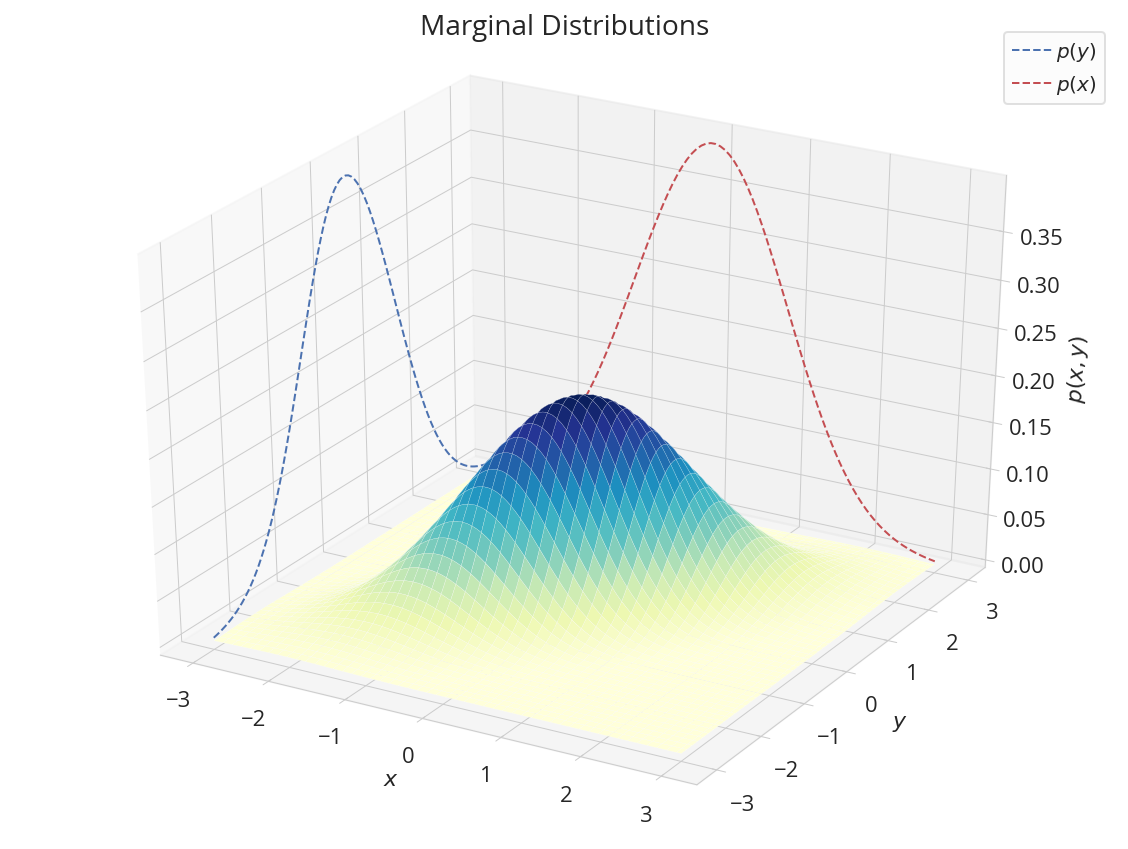

In [8]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')

ax.plot_surface(X1, X2, Z, rstride=2, cstride=2, linewidth=0.1, antialiased=True, cmap='YlGnBu')
ax.plot(x1, y1, z1, 'b--',zorder=-1, label='$p(y)$')
ax.plot(x2, y2, z2, 'r--',zorder=-1, label='$p(x)$')
ax.legend()

ax.tick_params(color='0.8')
ax.set(xlabel='$x$',ylabel="$y$",zlabel="$p(x,y)$",fc='none')
    
fig.suptitle("Marginal Distributions")

plt.tight_layout()
# plt.savefig('norm-dist-05.png',bbox_inches='tight',dpi=150)
plt.show()

### Conditional

$$
p(\mathbf{x} \mid \mathbf{y}) = \mathcal{N}(\mu_{x \mid y}, \Sigma_{x \mid y})
$$

$$
p(\mathbf{y} \mid \mathbf{x}) = \mathcal{N}(\mu_{y \mid x}, \Sigma_{y \mid x})
$$

$$
\begin{split}
\mu_{x \mid y} & = \mu_x + CB^{-1}(\mathbf{y}-\mu_y), \quad 
\Sigma_{x \mid y} & = A - CB^{-1}C^\top = \tilde{A}^{-1}
\end{split}
$$

$$
\begin{split}
\mu_{y \mid x} & = \mu_y + C^\top A^{-1}(\mathbf{x}-\mu_x), \quad 
\Sigma_{y \mid x} & = B - C^\top A^{-1}C = \tilde{B}^{-1}
\end{split}
$$

In [9]:
A, B, C = cov[0, 0], cov[1, 1], cov[0, 1]

x_cond, y_cond = -1, 1

mean_xy = mean[0] + (C * (1/B) * (y_cond - mean[1]))
cov_xy = A - C * (1/B) * C

mean_yx = mean[1] + (C * (1/A) * (x_cond - mean[0]))
cov_yx = B - (C * (1/A) * C)

In [10]:
nyx, nxy = tfd.Normal(mean_yx, cov_yx), tfd.Normal(mean_xy, cov_xy)

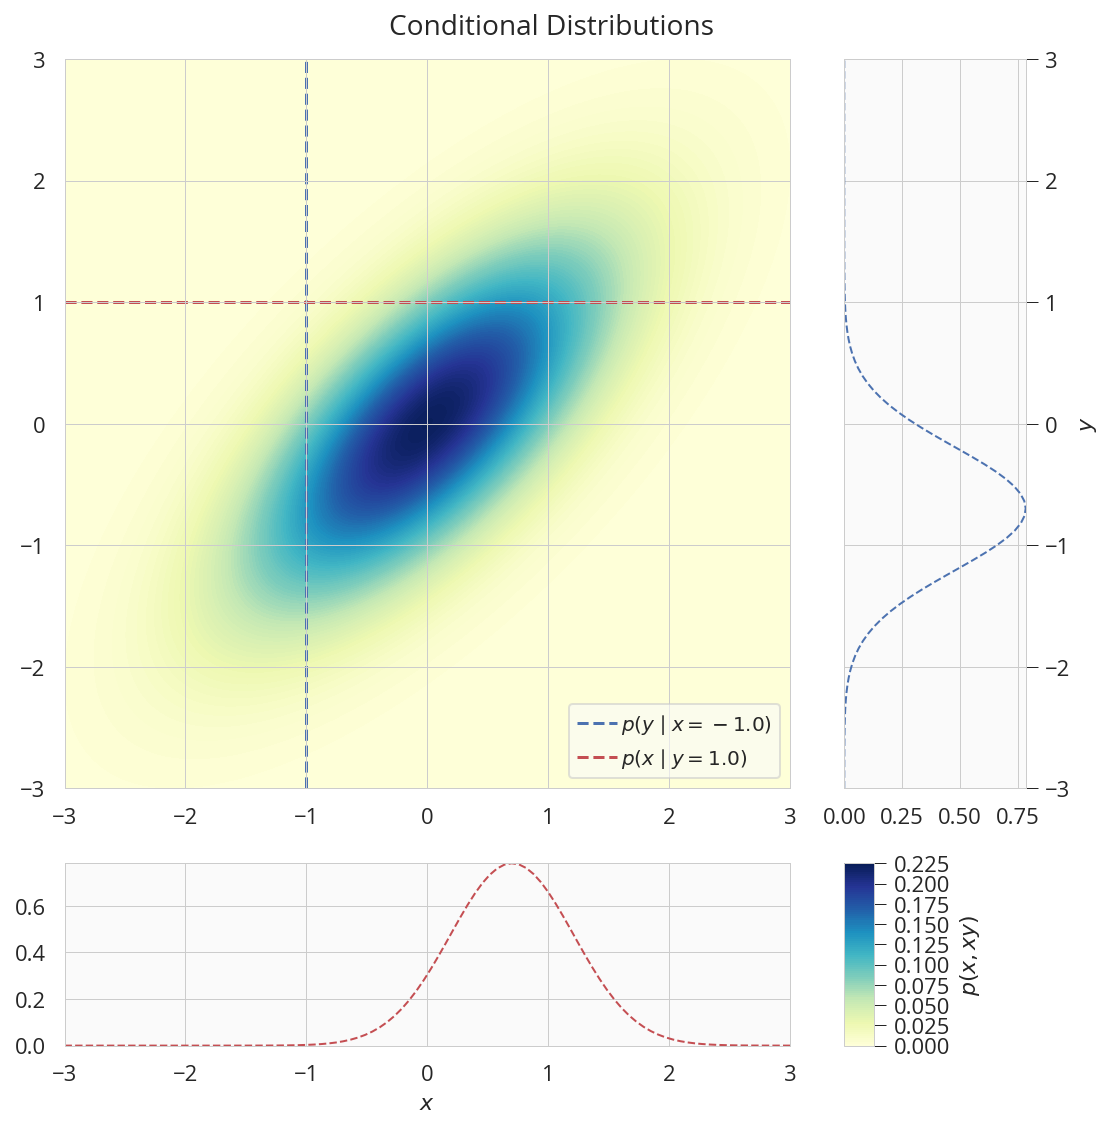

In [11]:
fig = plt.figure(figsize=(8, 8))

gs = GridSpec(2, 2, width_ratios=[8,2], height_ratios=[8,2])

ax = plt.subplot(gs[0])
con = ax.contourf(X1, X2, Z, 100, cmap='YlGnBu')
ax.plot([x_cond,x_cond], [-3,3], 'b--', lw=1.5, label='$p(y \mid x={:.1f})$'.format(x_cond))
ax.plot([-3,3], [y_cond,y_cond], 'r--', lw=1.5, label='$p(x \mid y={:.1f})$'.format(y_cond))
ax.set(axisbelow=False)
ax.legend(loc="lower right")
ax.autoscale(tight=True)

ax = plt.subplot(gs[1])
ax.plot(nyx.prob(y), y, 'b--')
ax.set(ylabel='$y$')
ax.yaxis.set_label_position('right')
ax.yaxis.set_ticks_position('right')
ax.autoscale(tight=True)

ax = plt.subplot(gs[2])
ax.plot(x, nxy.prob(x), 'r--')
ax.set(xlabel='$x$')
ax.autoscale(tight=True)

ax = plt.subplot(gs[3])
ax.set_visible(False)
cax = make_axes_locatable(ax).append_axes('left', size='20%',pad=0)
cbar = fig.colorbar(con, cax=cax)
cbar.ax.set_ylabel('$p(x, xy)$')

fig.suptitle('Conditional Distributions')

plt.tight_layout(rect=[0, 0, 1, 0.97])
# plt.savefig('norm-dist-06.png',bbox_inches='tight',dpi=150)
plt.show()

In [12]:
x1, y1, z1 = x, np.repeat(y_cond,100), nyx.prob(y).numpy()
x2, y2, z2 = np.repeat(x_cond,100), y, nxy.prob(x).numpy()

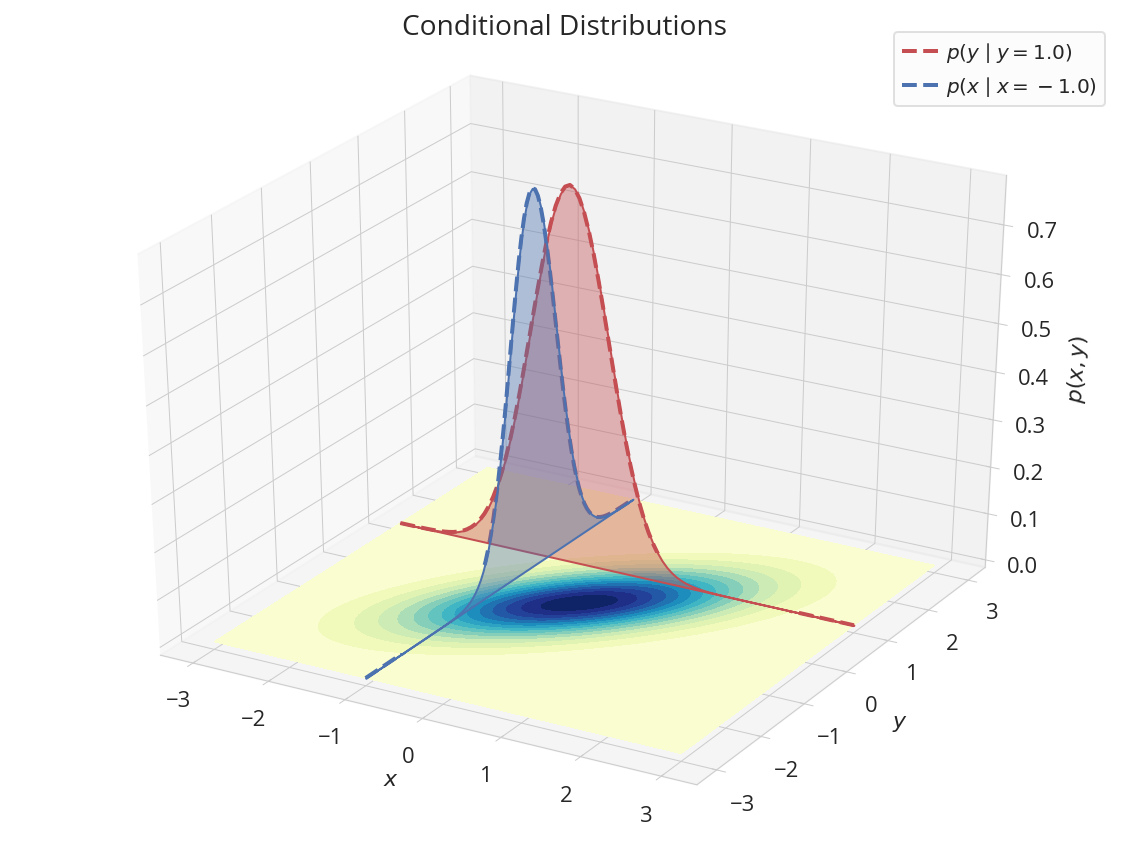

In [13]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')

ax.plot(x1, y1, z1, 'r--', lw=2, label='$p(y \mid y={:.1f})$'.format(y_cond),zorder=2)
ax.plot(x2, y2, z2, 'b--', lw=2, label='$p(x \mid x={:.1f})$'.format(x_cond),zorder=2)
ax.add_collection3d(Poly3DCollection([list(zip(x1, y1, z1))],color='r',alpha=0.4))
ax.add_collection3d(Poly3DCollection([list(zip(x2, y2, z2))],color='b',alpha=0.4))
ax.contourf(X1, X2, Z, 15, zdir='z', offset=0, cmap='YlGnBu')

ax.tick_params(color='0.8')
ax.set(xlabel='$x$',ylabel="$y$",zlabel="$p(x,y)$",fc='none')
ax.legend()
    
fig.suptitle("Conditional Distributions")

plt.tight_layout()
# plt.savefig('norm-dist-07.png',bbox_inches='tight',dpi=150)
plt.show()

## Refereneces

* [Multivariate normal distribution](https://peterroelants.github.io/posts/multivariate-normal-primer/)
* [Visualizing the bivariate Gaussian distribution](https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/)
* [CS229: Machine Learning](http://cs229.stanford.edu/)
* [多変量正規分布を理解する](https://math-note.com/multivariate-normal-distribution/)
* [一次元の正規分布から多次元正規分布へ - HELLO CYBERNETICS](https://www.hellocybernetics.tech/entry/2016/10/06/111153)